# Summary

Recently (possibly since upgrading to openai 0.18.1?), querying openai causes invalid URL errors. Here are some notes from yesterday's troubleshooting session.

- curl works, python doesn't.
- Not just codex, now nox openai engines work w/ python. Maybe due to updating pip package? Temporarily upped billing limit to try other models.
- Restarted kernel and gpt query works again w/ ada. BUT after I import openai explicitly, that fails too. That must be a clue.
- Tried uninstalling, reinstalling, opened new tmux pane. Still same error.
- Tried deleting 'openai' object and then importing jabberwocky. This does work!?
- If I re-import openai after that, gpt.query still works. But openai.completion while codex does not.
- If I import openai FROM jabberwocky openai_utils, codex query still fails. But gpt.query works. And openai.Completion works w/ engine ada!
- Conclusion: maybe it is codex-specific then?

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [494]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

from jabberwocky.config import C
from htools import *

/Users/hmamin/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cd_root()

Current directory: /Users/hmamin/jabberwocky


In [4]:
j_kwargs = {'prompt': 'a', 'max_tokens': 1, 'engine_i': 0}
ada_kwargs = {'prompt': 'a', 'max_tokens': 1, 'engine': 'text-ada-001'}
code_kwargs = {'prompt': 'a', 'max_tokens': 1, 'engine': 'code-davinci-001'}

## Jabberwocky

In [5]:
from jabberwocky.openai_utils import load_prompt, load_openai_api_key, \
    GPTBackend
import jabberwocky.openai_utils as oautils

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.


In [6]:
gpt = GPTBackend()
gpt

GPTBackend <current_name: openai>

In [7]:
res = gpt.query(**j_kwargs)

{'max_tokens': 1, 'engine_i': 0, 'prompt': 'a', 'meta': {'backend_name': 'openai', 'query_func': 'query_gpt3', 'datetime': 'Mon Apr 25 19:42:34 2022'}}


In [8]:
res

([''],
 [{'text': '\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}])

## openai 0.6.2

In [9]:
import openai

In [10]:
openai.version.VERSION

'0.18.1'

In [11]:
with open('/Users/hmamin/.openai', 'r') as f:
    openai.api_key = f.read().strip()

In [12]:
# oautils.openai == openai

In [13]:
res = openai.Completion.create(**code_kwargs)

In [14]:
res

<OpenAIObject text_completion id=cmpl-515RxlKh9094yUQFyFqI4pVMKtjrV at 0x11f6c0b48> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": "nt"
    }
  ],
  "created": 1650940961,
  "id": "cmpl-515RxlKh9094yUQFyFqI4pVMKtjrV",
  "model": "code-davinci:001",
  "object": "text_completion"
}

## openai 0.18.1

In [15]:
import openai

In [16]:
openai.version.VERSION

'0.18.1'

In [11]:
with open('/Users/hmamin/.openai', 'r') as f:
    openai.api_key = f.read().strip()

In [12]:
# oautils.openai == openai

In [13]:
res = openai.Completion.create(**code_kwargs)

In [14]:
res

<OpenAIObject text_completion id=cmpl-515ItOmu7H4oHPA2yyDXpfHpteeby at 0x1245a1bf8> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": ""
    }
  ],
  "created": 1650940399,
  "id": "cmpl-515ItOmu7H4oHPA2yyDXpfHpteeby",
  "model": "code-davinci:001",
  "object": "text_completion"
}

In [14]:
from jabberwocky.openai_utils import load_prompt, load_openai_api_key, \
    GPTBackend
import jabberwocky.openai_utils as oautils

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.


In [15]:
gpt = GPTBackend()
gpt

GPTBackend <current_name: openai>

In [16]:
res = gpt.query(**j_kwargs)

{'max_tokens': 1, 'engine_i': 0, 'prompt': 'a', 'meta': {'backend_name': 'openai', 'query_func': 'query_gpt3', 'datetime': 'Sun Apr 24 15:42:59 2022'}}


In [17]:
res

([''],
 [{'text': '\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}])

## Takeaways

Could not reproduce error with either old or new version of openai package. Maybe ipython handles things differently from jupyter?

Update: could not reproduce in ipython either. No new openai version has been released in the last few days so it's not like they fixed something. Maybe it was an autoreload thing?

## Stop words in streaming mode

In [146]:
from collections import deque
from transformers import GPT2Tokenizer

In [98]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [100]:
tokenizer_j = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-j-6B')

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [199]:
list(tokenizer.get_vocab().items())[-5:]

[('Ġregress', 50252),
 ('ĠCollider', 50253),
 ('Ġinformants', 50254),
 ('Ġgazed', 50255),
 ('<|endoftext|>', 50256)]

In [119]:
tokenizer.tokenize('Sylvia: Hi.\n\nMe: Hello<END>')

['S',
 'yl',
 'via',
 ':',
 'ĠHi',
 '.',
 'Ċ',
 'Ċ',
 'Me',
 ':',
 'ĠHello',
 '<',
 'END',
 '>']

In [200]:
tokenizer.tokenize('Sylvia: Hi.\n\nMe: Hello<|endoftext|>')

['S',
 'yl',
 'via',
 ':',
 'ĠHi',
 '.',
 'Ċ',
 'Ċ',
 'Me',
 ':',
 'ĠHello',
 '<|endoftext|>']

In [120]:
tokenizer_j.tokenize('Sylvia: Hi.\n\nMe: Hello<END>')

['S',
 'yl',
 'via',
 ':',
 'ĠHi',
 '.',
 'Ċ',
 'Ċ',
 'Me',
 ':',
 'ĠHello',
 '<',
 'END',
 '>']

In [17]:
gpt = GPTBackend()
gpt.backends()

['openai', 'gooseai', 'huggingface', 'hobby', 'banana', 'repeat', 'mock']

In [18]:
gpt.switch('mock')

Switching openai backend to "mock".


In [19]:
for tok, full in gpt.query('This is the last time', stream=True):
    print(tok)
    print(full)
    print(spacer())

{'stream': True, 'prompt': 'This is the last time', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Mon Apr 25 19:42:57 2022'}}
 a
{'finish_reason': None, 'index': 0, 'logprobs': <OpenAIObject at 0x11f6b3db0> JSON: {
  "text_offset": [
    0
  ],
  "token_logprobs": [
    -1.3818359375
  ],
  "tokens": [
    " a"
  ],
  "top_logprobs": [
    {
      " a": -1.3818359375,
      " my": -2.384765625,
      " the": -1.8720703125
    }
  ]
}, 'text': ' a', 'token_index': 0, 'prompt_index': 0}

-------------------------------------------------------------------------------

 bit
{'finish_reason': None, 'index': 0, 'logprobs': <OpenAIObject at 0x11f6b3f68> JSON: {
  "text_offset": [
    2
  ],
  "token_logprobs": [
    -4.75390625
  ],
  "tokens": [
    " bit"
  ],
  "top_logprobs": [
    {
      " big": -1.83984375,
      " day": -2.53125,
      " very": -2.916015625
    }
  ]
}, 'text': ' bit', 'token_index': 1, 'prompt_index': 0}

------------------------------

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:721: UserWarning: strip_output=True is not supported in stream mode. Automatically setting it to False.
  warnings.warn('strip_output=True is not supported in stream '
/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:726: UserWarning: Streaming mode does not support manual truncation of stop phrases and your current backend has limited support for truncation.
  'Streaming mode does not support manual truncation of '


In [20]:
conv = oautils.ConversationManager(verbose=False)
conv

In [90]:
gpt.switch('openai')
with conv.converse('Sylvia Plath'):
    res = conv.query('Hi.', engine_i=0,
                     stream=True, max_tokens=25)

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.
Switching openai backend to "openai".
{'engine_i': 0, 'temperature': 0.5, 'max_tokens': 25, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': True, 'prompt': 'This is a conversation with Sylvia Plath. Sylvia Plath (October 27, 1932 - February 11, 1963) was an American poet, novelist, and short-story writer. She is credited with advancing the genre of confessional poetry and is best known for two of her published collections, The Colossus and Other Poems (1960) and Ariel (1965), as well as The Bell Jar, a semi-autobiographical novel published shortly before her death in 1963.\n\nMe: Hi.\n\nSylvia Plath:', 'meta': {'backend_name': 'openai', 'query_func': 'query_gpt3', 'datetime': 'Mon Apr 25 20:25:41 2022'}}


In [91]:
res2 = list(res)

In [92]:
[row[0] for row in res2]

[' Hi', '.', ' How', ' are', ' you', '?', '']

In [208]:
res = [(' Hi',
  {'text': ' Hi',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('.',
  {'text': '.',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' How',
  {'text': ' How',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' are',
  {'text': ' are',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' you',
  {'text': ' you',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('?',
  {'text': '?',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('',
  {'text': '',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
('<|endoftext|>',
  {'text': '<|endoftext|>',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
(' ',
 {'text': ' ',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('Hey',
 {'text': 'Hey',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
  (' there',
 {'text': ' there',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}),
]

Notes on usage:

- When NOT in stream mode, gpt.query uses `openai_utils.truncate_at_first_stop`. This executes on a single completion (np=1, nc=1) at a time.
- When in stream mode, it uses `utils.stream_response`. This calls `stream_openai_generator` if the query func has param 'stream' and does some custom logic in the same stream_response func otherwise.
- Possible way to utilize new stream func (when done): use it in stream_openai_generator? Will be unnecessary for openai (basically just for gooseai, since other query funcs don't support streaming at all) but shouldn't be harmful, in theory. Then update stream_response logic if necessary (might be easier to just convert to str/list and rstrip/replace, since these aren't really streamed).

In [209]:
len(tokenizer.tokenize('<END>'))

3

In [213]:
# Uses lookahead so we don't return any tokens past stop. Might be tricky to
# use w/ multiple stopwords bc diff lengths.
# TODO: update to work when np > 1 and/or nc > 1.
def stream_with_stop(gen, stop_word='<|endoftext|>', stop_word_n_tokens=1):
    # stop_word_n_tokens: number of tokens stop_word consists of when using 
    # the appropriate gpt tokenizer (I vaguely recall this may differ for
    # gpt-j models).
    full_text = ''
    q = deque()
    for i, (text, full) in enumerate(gen):
        full_text += text
        q.append((text, full))
        if i < stop_word_n_tokens: continue
        if full_text.endswith(stop_word):
            q[0][-1]['finish_reason'] = 'stop'
            yield q.popleft()
            break
        yield q.popleft()        

In [211]:
for tok, full in res:
    print(repr(tok), full['finish_reason'])

' Hi' None
'.' None
' How' None
' are' None
' you' None
'?' None
'' None
'<|endoftext|>' None
' ' None
'Hey' None
' there' length


In [212]:
for tok, full in stream_with_stop(res):
    print(repr(tok), full['finish_reason'])

' Hi' None
'.' None
' How' None
' are' None
' you' None
'?' None
'' stop


## Cost estimator

Since the stopword removal for a backend with native streaming currently only helps gooseai, I want to get a better sense of how often gooseai is actually cost effective. Write function to compute:
- openai cost
- gooseai cost
- which one is cheaper
- evaluate over a range of possible prompt lengths and output lengths
    - maybe plot
- consideration: we often specify max_tokens but the actual response could be shorter. Maybe provide an option to use some sort of expected value of return a distribution of possible prices, rather than a single price?

In [392]:
from jabberwocky.openai_utils import EngineMap, GPTBackend

In [383]:
# Slightly outdated - see jabbewocky.openai_utils version for most up to date.
# class EngineMap:
#     """Lets us specify engines more flexibly and obtain equivalents for
#     different backends. E.g. for an openai engine=0 or engine='ada' or
#     engine='text-ada-001', what gooseai engine does this map to?
#     """

#     bases = [
#         'ada',
#         'babbage',
#         'curie',
#         'davinci'
#     ]
#     backend_engines = C.backend_engines

#     @classmethod
#     def get(cls, engine, backend=None, infer=False, default=None,
#             openai_passthrough=True):
#         """

#         Parameters
#         ----------
#         engine: int or str
#             See class docstring for .
#         backend
#         infer: bool
#             If true and the specified backend does not have an engine matching
#             the desired engine, we check for progressively weaker engines
#             trying to find something to return.
#         default: any
#             Value to return if we fail to resolve the engine under the current
#             backend.
#         openai_passthrough: bool
#             If True and openai is the specified backend and engine is a str,
#             we simply return the input.
#             E.g. if True, 'code-ada-001' -> 'code-ada-001' and 'ada' .

#         Returns
#         -------
#         str or None: Technically, can be any value if you specify a different
#         `default`. But typically it will be the name of the current/specified
#         backend's equivalent engine. This is best explained by example (below).

#         Examples
#         --------
#         >>> EngineMap.get(1, 'gooseai')
#         'gpt-j-6b'

#         >>> with gpt('huggingface'):
#         >>>     print(EngineMap.get('ada'))
#         'gpt-neo-2.7B'

#         >>> EngineMap.get('text-davinci-002', 'huggingface', infer=True)
#         # UserWarning: No engine=text-davinci-002 equivalent for backend
#         # huggingface.Trying to auto-infer best option.
#         'gpt-j-6B'
#         """
#         # Store this for potential error message later.
#         user_engine = engine
#         if isinstance(engine, int):
#             if engine not in range(4):
#                 raise ValueError(
#                     f'Received invalid engine value: {engine}. If engine is '
#                     'specified as an integer, it must lie in [0, 3].'
#                 )
#             engine_i = engine
#         else:
#             base = cls._openai_base_engine(engine)
#             engine_i = cls.bases.index(base)

#         backend = backend or GPTBackend.current()
#         if backend not in cls.backend_engines:
#             return default

#         backend_engines = cls.backend_engines[backend]
#         if backend == 'openai' and openai_passthrough \
#                 and isinstance(user_engine, str):
#             if user_engine not in cls.bases + backend_engines:
#                 # We do still have some basic validation above that checks
#                 # that one of the openai bases is present in the name.
#                 warnings.warn(
#                     f'Allowing engine "{engine}" to pass through because '
#                     f'openai_passthrough=True. We trust you to make sure this '
#                     f'is a valid engine.'
#                 )
#             return user_engine

#         engine = backend_engines[engine_i]
#         if not engine:
#             msg = f'No engine={user_engine} equivalent for backend {backend}.'
#             if infer:
#                 warnings.warn(msg + 'Trying to auto-infer best option.')
#                 while engine_i > 0 and not engine:
#                     engine_i -= 1
#                     engine = backend_engines[engine_i]
#             else:
#                 return default
            
#         if 'code' in engine and backend != 'openai':
#             warnings.warn(f'{backend} backend does not provide code-specific '
#                           'models at the moment. We\'re returning the closest'
#                           ' generic model.')
#         return engine

#     @classmethod
#     def _openai_base_engine(cls, engine: str):
#         """Extract openai base engine name (e.g. 'ada') from a potentially
#         longer string (e.g. 'text-ada-001'). If you pass in the short name, it
#         should just return itself.

#         Parameters
#         ----------
#         engine: str
#             E.g. 'code-babbage-001', 'text-ada-001', 'davinci'

#         Returns
#         -------
#         str
#         """
#         matches = [chunk for chunk in engine.split('-')
#                    if chunk in cls.bases]
#         if not matches:
#             raise ValueError(f'Engine "{engine}" does not contain any of the '
#                              f'recognized openai bases {cls.bases}.')
#         if len(matches) > 1:
#             raise ValueError(f'Engine "{engine}" contains multiple matches '
#                              f'among the recognized openai bases '
#                              f'{cls.bases}.')

#         return matches[0]

#     # TODO: rm?
#     @classmethod
#     def _nonbase_openai_name(cls, engine):
#         """Check if engine is plausibly an openai engine name but not a base
#         one (e.g. 'text-davinci-001' or 'code-ada-001' map to True,
#         'ada' or 'other word' map to False).

#         Parameters
#         ----------
#         engine: str

#         Returns
#         -------
#         bool
#         """
#         try:
#             _ = cls._openai_base_engine(engine)
#             assert engine not in cls.bases, \
#                 f'Engine {engine} found in cls.bases.'
#             return True
#         except Exception as e:
#             return False

In [393]:
gpt = GPTBackend()

In [394]:
EngineMap.get(3, 'hobby')

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:593: UserWarning: No engine=3 equivalent for backend hobby.Trying to auto-infer best option.
  warnings.warn(msg + 'Trying to auto-infer best option.')


'gpt-j-6B'

In [375]:
backends = GPTBackend.backends()
engine_inputs = [
    0, 1, 2, 3, 'ada', 'babbage', 'curie', 'davinci', 'text-ada-001', 
    'text-babbage-001', 'text-curie-001', 'text-davinci-002', 9, 'typo', 
    'code-ada-001'
]

for backend in backends:
    for engine in engine_inputs:
        print(backend, engine)
        try:
            tmp = EngineMap.get(engine, backend)
            print('\t', repr(tmp))
        except Exception as e:
            print(e)
            try:
                tmp = EngineMap.get(engine, backend, infer=True)
                print('\tInferred: ', repr(tmp))
            except Exception as e:
                print('Inferred engine failed too. ' + str(e))
        print(spacer())

openai 0
	 'text-ada-001'

-------------------------------------------------------------------------------

openai 1
	 'text-babbage-001'

-------------------------------------------------------------------------------

openai 2
	 'text-curie-001'

-------------------------------------------------------------------------------

openai 3
	 'text-davinci-002'

-------------------------------------------------------------------------------

openai ada
	 'ada'

-------------------------------------------------------------------------------

openai babbage
	 'babbage'

-------------------------------------------------------------------------------

openai curie
	 'curie'

-------------------------------------------------------------------------------

openai davinci
	 'davinci'

-------------------------------------------------------------------------------

openai text-ada-001
	 'text-ada-001'

-------------------------------------------------------------------------------

openai text-bab

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: Allowing engine "code-ada-001" to pass through because openai_passthrough=True. We trust you to make sure this is a valid engine.


In [361]:
with gpt('huggingface'):
    print(EngineMap.get('ada'))

Switching openai backend to "huggingface".
gpt-neo-2.7B
Switching  backend back to "mock".


In [362]:
EngineMap.get('text-davinci-002', 'huggingface', infer=True)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: UserWarning: No engine=text-davinci-002 equivalent for backend huggingface.Trying to auto-infer best option.


'gpt-j-6B'

In [366]:
EngineMap.get('davinci', 'openai', openai_passthrough=True)

'davinci'

In [367]:
EngineMap.get('davinci', 'openai', openai_passthrough=False)

'text-davinci-002'

In [373]:
EngineMap.get('ada', 'openai', openai_passthrough=False)

'text-ada-001'

In [344]:
backend = 'openai'
for engine in engine_inputs:
    print(backend, engine)
    try:
        tmp = EngineMap.get(engine, backend, openai_base=True)
        print('\t', repr(tmp))
    except Exception as e:
        print(e)
        try:
            tmp = EngineMap.get(engine, backend, infer=True, openai_base=True)
            print('\tInferred: ', repr(tmp))
        except Exception as e:
            print('Inferred engine failed too. ' + str(e))
    print(spacer())

openai 0
	 'ada'

-------------------------------------------------------------------------------

openai 1
	 'babbage'

-------------------------------------------------------------------------------

openai 2
	 'curie'

-------------------------------------------------------------------------------

openai 3
	 'davinci'

-------------------------------------------------------------------------------

openai ada
	 'ada'

-------------------------------------------------------------------------------

openai babbage
	 'babbage'

-------------------------------------------------------------------------------

openai curie
	 'curie'

-------------------------------------------------------------------------------

openai davinci
	 'davinci'

-------------------------------------------------------------------------------

openai text-ada-001
	 'ada'

-------------------------------------------------------------------------------

openai text-babbage-001
	 'babbage'

-----------------------

In [399]:
EngineMap._openai_base_engine('text-davinci-002')

'davinci'

In [409]:
gpt.engine('text-davinci-002', backend='openai', openai_passthrough=False, basify=True)

'davinci'

In [404]:
gpt.engine('text-davinci-002', backend='gooseai', openai_passthrough=False)

'gpt-neo-20b'

In [533]:
def estimate_cost(completion_length, prompt_length=None, prompt=None, 
                  engines=(0, 1, 2, 3), tokenizer=None):
    # Pass in engines=None to get ALL possible engine prices.
    xor_none(prompt_length, prompt)
    xor_none(prompt_length, tokenizer)
    
    if engines:
        engines = tolist(engines)
        openai_names = [gpt.engine(engine, backend='openai', 
                                   openai_passthrough=False, basify=True)
                       for engine in engines]
        gooseai_names = [gpt.engine(engine, backend='gooseai', basify=True)
                         for engine in engines]
        
    # Unlike gooseai, openai charges for both prompt and generation tokens.
    # We convert their prices to cents per token.
    # And/or support passing in engine_i int?
    openai_prices = {
        'ada': {'per': .0008 / 1_000},
        'babbage': {'per': .0012 / 1_000},
        'curie': {'per': .0060 / 1_000},
        'davinci': {'per': .0600 / 1_000},
    }
    
    # Gooseai base prices (in cents) cover the input and the first 25 tokens 
    # of the output. `Per` prices are cents per token.
    gooseai_prices = {
        'gpt-neo-20b': {'base': 0.002650, 'per': 0.000063},
        'fairseq-13b': {'base': 0.001250, 'per': 0.000036},
        'fairseq-6-7b': {'base': 0.000450, 'per': 0.000012},
        'gpt-j-6b': {'base': 0.000450, 'per': 0.000012},
        'gpt-neo-2-7b': {'base': 0.000300, 'per': 0.000008},
        'fairseq-2-7b': {'base': 0.000300, 'per': 0.000008},
        'gpt-neo-1-3b': {'base': 0.000110, 'per': 0.000003},
        'fairseq-1-3b': {'base': 0.000110, 'per': 0.000003},
        'gpt-neo-125m': {'base': 0.000035, 'per': 0.000001},
        'fairseq-125m': {'base': 0.000035, 'per': 0.000001},
    }

    
    prompt_length = prompt_length or len(tokenizer.tokenize(prompt))
    if engines:
        gooseai_prices = select(gooseai_prices, keep=gooseai_names)
        openai_prices = select(openai_prices, keep=openai_names)
    gooseai_resolved = [
        ('gooseai', name, 
         prices['base'] + prices['per']*max(0, completion_length - 25))
        for name, prices in gooseai_prices.items()
    ]
    openai_resolved = [
        ('openai', name, prices['per'] * (prompt_length + completion_length))
        for name, prices in openai_prices.items()
    ]
    # Prices are returned in cents.
    df = pd.DataFrame(
        gooseai_resolved + openai_resolved,
        columns=['backend', 'engine', 'cost_cents']
    ).sort_values('cost_cents', ascending=True).reset_index(drop=True)
    return {**df.iloc[0].to_dict(),
            'full': df}

In [534]:
prompt = load_prompt('debate', 'A hot dog is a sandwich.')['prompt']
cost_res = estimate_cost(completion_length=300, prompt=prompt, 
                         tokenizer=tokenizer)
cost_res.pop('full').pprint()
cost_res

debate: Non-zero frequency penalty was initially included by accident, but in at least 1 test removing it noticeably worsened results.
-------------------------------------------------------------------------------



,backend,engine,cost_cents
0,openai,ada,0.000707
1,openai,babbage,0.001061
2,gooseai,gpt-neo-2-7b,0.002500
3,gooseai,gpt-j-6b,0.003750
4,openai,curie,0.005304
5,gooseai,fairseq-13b,0.011150
6,gooseai,gpt-neo-20b,0.019975
7,openai,davinci,0.053040


{'backend': 'openai', 'engine': 'ada', 'cost_cents': 0.0007072000000000001}

In [535]:
prompt_lengths = np.arange(1, 2048, 10)
completion_lengths = np.arange(1, 2048, 10)

In [536]:
cost_res = {
    (p_len, c_len): estimate_cost(c_len, prompt_length=p_len)
    for p_len, c_len in 
    tqdm(product(prompt_lengths, completion_lengths), 
         total=len(prompt_lengths) * len(completion_lengths))
    if p_len + c_len <= 2_048
}

  0%|          | 0/42025 [00:00<?, ?it/s]

In [537]:
len(cost_res)

21115

In [538]:
df_cost = pd.concat(
    [res['full'].assign(p_len=p, c_len=c,
                        ranking=lambda x: x.index.values,
                        i=i) 
     for i, ((p, c), res) in enumerate(tqdm(cost_res.items()))],
    axis=0
).reset_index(drop=True)

  0%|          | 0/21115 [00:00<?, ?it/s]

In [539]:
pd.crosstab(df_cost.ranking, df_cost.backend, normalize='index')\
    .style.highlight_max(axis=1)

backend,gooseai,openai
ranking,,
0,0.088942,0.911058
1,0.105328,0.894672
2,0.638930,0.361070
3,0.676107,0.323893
4,0.648923,0.351077
5,0.921857,0.078143
6,0.852190,0.147810
7,0.067724,0.932276


This generally makes sense - gooseai's pricing scheme is preferable when we have a long prompt with a short completion.

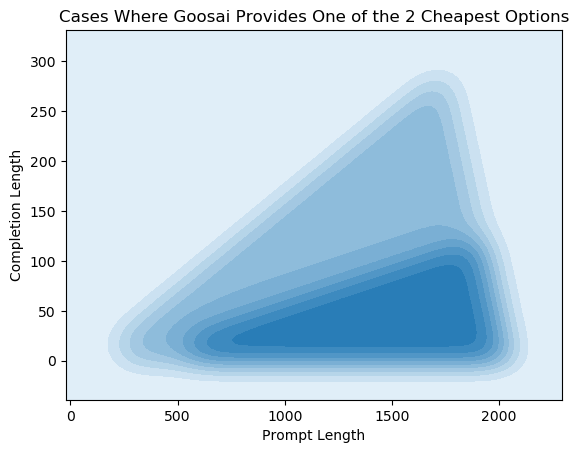

In [542]:
k = 2
sns.kdeplot(
    df_cost.loc[
        (df_cost.backend == 'gooseai') & (df_cost.ranking < k),
        ['p_len', 'c_len']
    ],
    shade=True
)
plt.xlabel('Prompt Length')
plt.ylabel('Completion Length')
plt.title(f'Cases Where Goosai Provides One of the {k} Cheapest Options')
plt.show()

In [677]:
def iter_engine_names(*args, **kwargs):
    for i in range(4):
        yield tuple(gpt.engine(i, backend=arg, **kwargs) for arg in args)

In [682]:
def iter_paid_engines(basify=True):
    yield from iter_engine_names('openai', 'gooseai', basify=basify)

In [684]:
for a, b in iter_paid_engines(False):
    print(a, b)

text-ada-001 gpt-neo-2-7b
text-babbage-001 gpt-j-6b
text-curie-001 fairseq-13b
text-davinci-002 gpt-neo-20b


In [678]:
list(iter_engine_names('openai', 'huggingface', 'gooseai', basify=True))

[('ada', 'gpt-neo-2.7B', 'gpt-neo-2-7b'),
 ('babbage', 'gpt-j-6B', 'gpt-j-6b'),
 ('curie', 'gpt-j-6B', 'fairseq-13b'),
 ('davinci', 'gpt-j-6B', 'gpt-neo-20b')]

In [635]:
def engine_heatmap(*engines):
    fig, ax = plt.subplots(1, len(engines), figsize=(12, 6))
    if listlike(ax): 
        ax = ax.flatten()
    else:
        ax = [ax]
        
    eng2costs = {}
    for engine, axi in zip(engines, ax):
        chunk = df_cost[df_cost.engine == engine]
        costs = np.zeros((chunk.p_len.max(), chunk.c_len.max()))
        eng2costs[engine] = costs
        for i, row in tqdm(chunk.iterrows(), total=chunk.shape[0]):
            costs[row.p_len - 1, row.c_len - 1] = row.cost_cents

        g = axi.contourf(np.arange(chunk.p_len.max()),
                         np.arange(chunk.c_len.max()), 
                         costs)
        axi.set_xlabel('Completion Length')
        axi.set_ylabel('Prompt Length')
        axi.set_title(f'{engine} Cost')
        fig.colorbar(g, ax=axi)
    plt.show()
    return eng2costs

In [670]:
def diff_histogram(openai_name, gooseai_name):
    diffs = (eng2costs[openai_name] - eng2costs[gooseai_name]).flatten()
    diffs = diffs[diffs != 0]
    pct_openai_more_expensive = (diffs > 0).mean()
    avg_diff = diffs.mean()
    print(f'Openai more expensive: {pct_openai_more_expensive:.2%}')
    print(f'Avg diff (openai - gooseai): {avg_diff:.3f}')
    plt.hist(diffs)
    plt.title(f'{openai_name} - {gooseai_name}')
    plt.show()

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

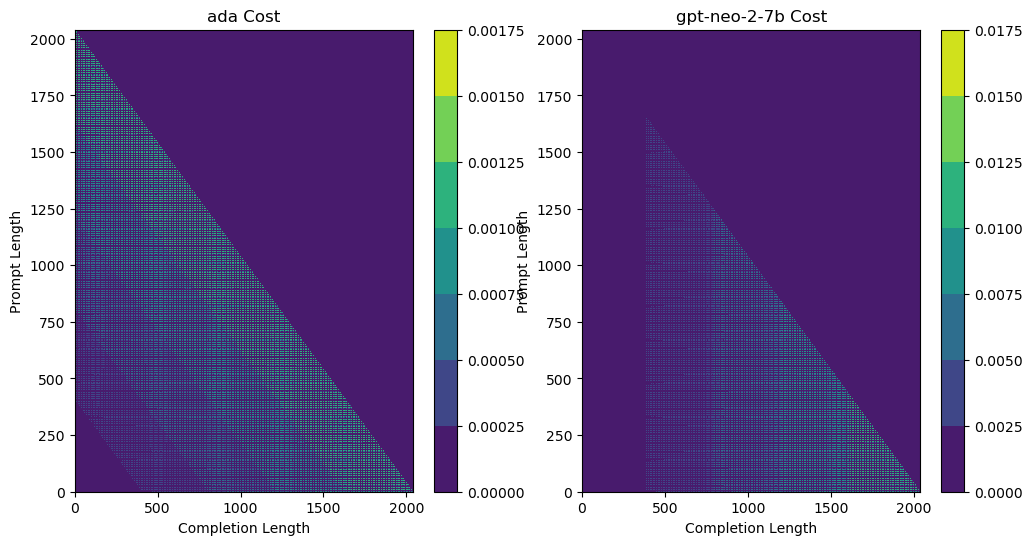

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

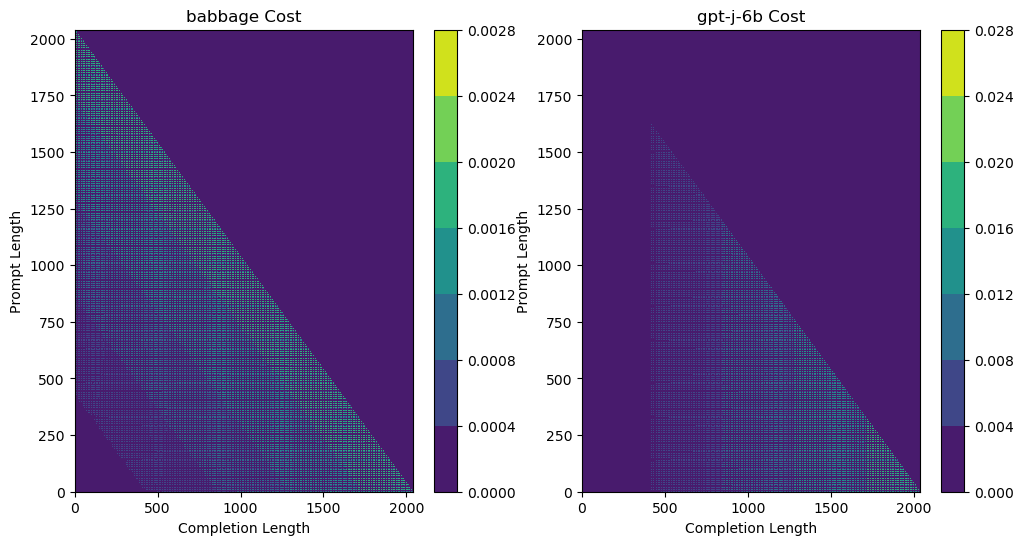

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

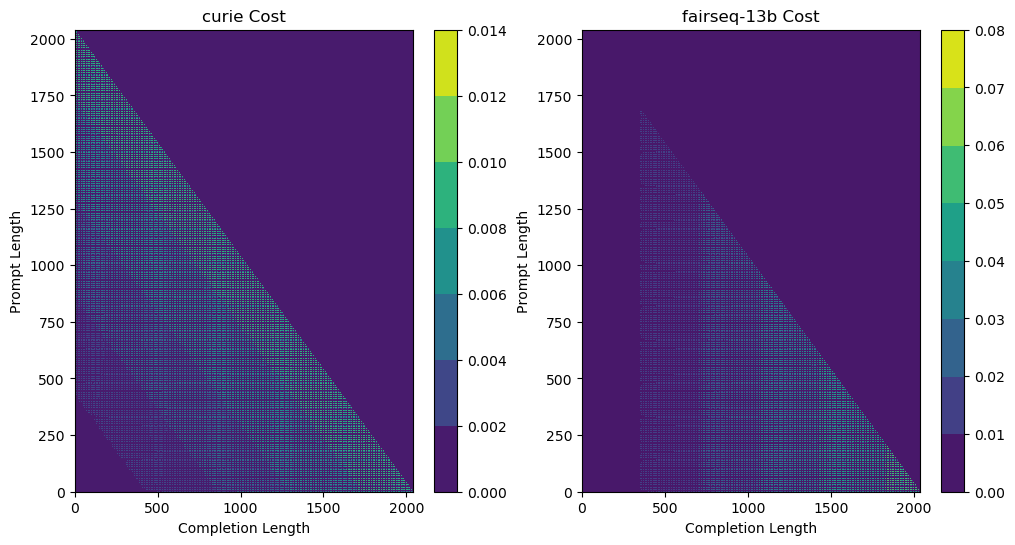

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

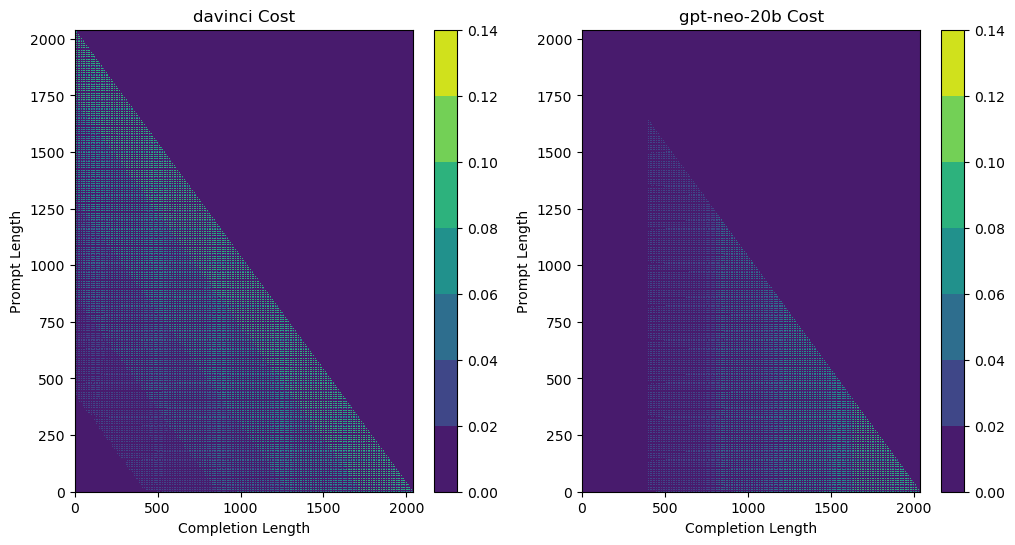

In [666]:
eng2costs = {}
for openai_name, gooseai_name in iter_paid_engines():
    tmp = engine_heatmap(openai_name, gooseai_name)
    eng2costs.update(tmp)

Openai more expensive: 8.89%
Avg diff (openai - gooseai): -0.004


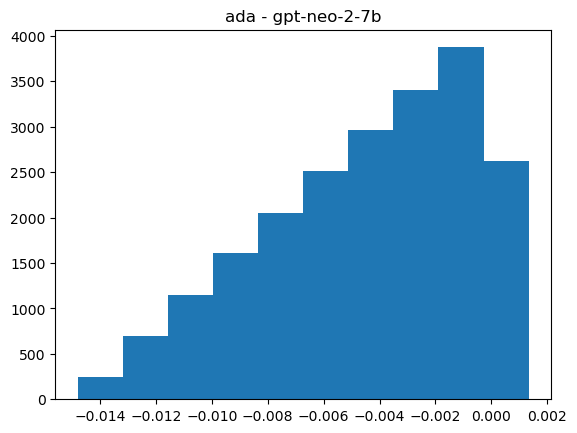

Openai more expensive: 8.89%
Avg diff (openai - gooseai): -0.007


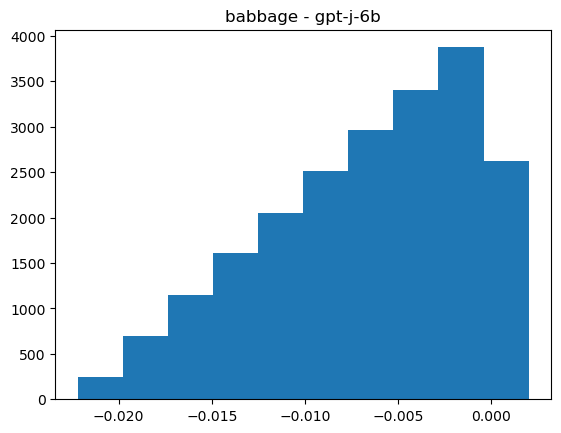

Openai more expensive: 15.83%
Avg diff (openai - gooseai): -0.017


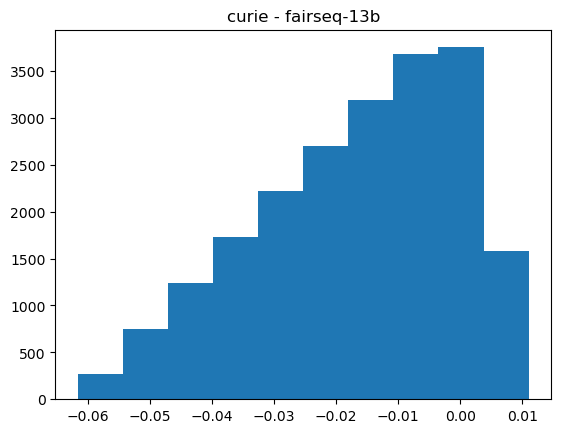

Openai more expensive: 93.23%
Avg diff (openai - gooseai): 0.038


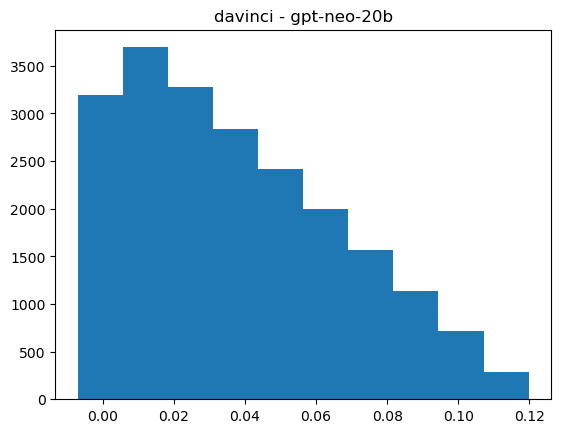

In [671]:
for openai_name, gooseai_name in iter_paid_engines():
    diff_histogram(openai_name, gooseai_name)

Gooseai's davinci equivalent wins out more often but openai's cheaper models usually win. But it's very length dependent - a lot of openai's "wins" are probably when prompts are very long. Could probably find a better way to visualize this. Regardless, I think that basic bit of intuition is enough for now, and aside from that we can probably implement an auto-backend selector.